In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

## PREPARING DATA

In [2]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
#Training set:  852 triples annotated as correct and incorrect

data = pd.read_csv('annotatedTriples.csv',sep="\t", decimal=",", index_col=False)
data = data[(data['VALIDATION']<3)]
#VALIDATION = 1: CORRECT
#VALIDATION = 2: INCORRECT
print("Size: ", data.shape)
#data1=data[data['ORIGIN']=='f']
data.head(3)

Size:  (852, 69)


,2,3,4,5,6,7,8,9,10,11,...,VALIDATION,ORIGIN,CLUSTER,TABLE,CELL,NAME_COL1,NAME_COL2,ENTITY_COL1,PREDICATE,ENTITY_COL2
0,9,11,6,1.833333,24,-1,2,5,5,1.0,...,2,t,0,203221.9,13:-1:2,protag_article@3,candid@3,https://en.wikipedia.org/wiki/Electoral_result...,P1346 :winner@en,https://en.wikipedia.org/wiki/Voter_turnout :Q...
1,8,6,6,1.000000,11,-1,1,5,5,1.0,...,2,t,0,238845.8,4:-1:1,protag_article@3,2__parti@3,https://en.wikipedia.org/wiki/Gravesham_Boroug...,P488-1 :chairperson@en,https://en.wikipedia.org/wiki/Labour_Party_(UK...
2,8,13,6,2.166667,28,-1,2,6,6,1.0,...,2,t,0,242238.8,17:-1:2,protag_article@3,candid@3,https://en.wikipedia.org/wiki/Electoral_result...,P488 :chairperson@en,https://en.wikipedia.org/wiki/Voter_turnout :Q...


In [4]:
contextual = pd.read_csv('contextual_triples_new.csv',sep="\t", decimal=',',index_col=False, dtype={'TABLE':str})
contextual=contextual[(contextual['VALIDATION']<=3)]

**Adding new feature (Number tables by cluster)**

In [5]:
clusters = pd.read_csv('numTablesByCluster.csv',sep="\s+", index_col=False)
clusters=clusters.rename(columns={'cluster': 'CLUSTER', '1':'65'})
clusters.head(2)

,65,CLUSTER
0,82793,0
1,59658,1


In [6]:
data=pd.merge(data, clusters, on=['CLUSTER'])
data.head()

,2,3,4,5,6,7,8,9,10,11,...,ORIGIN,CLUSTER,TABLE,CELL,NAME_COL1,NAME_COL2,ENTITY_COL1,PREDICATE,ENTITY_COL2,65
0,9,11,6,1.833333,24,-1,2,5,5,1.0,...,t,0,203221.9,13:-1:2,protag_article@3,candid@3,https://en.wikipedia.org/wiki/Electoral_result...,P1346 :winner@en,https://en.wikipedia.org/wiki/Voter_turnout :Q...,82793
1,8,6,6,1.000000,11,-1,1,5,5,1.0,...,t,0,238845.8,4:-1:1,protag_article@3,2__parti@3,https://en.wikipedia.org/wiki/Gravesham_Boroug...,P488-1 :chairperson@en,https://en.wikipedia.org/wiki/Labour_Party_(UK...,82793
2,8,13,6,2.166667,28,-1,2,6,6,1.0,...,t,0,242238.8,17:-1:2,protag_article@3,candid@3,https://en.wikipedia.org/wiki/Electoral_result...,P488 :chairperson@en,https://en.wikipedia.org/wiki/Voter_turnout :Q...,82793
3,15,10,6,1.666667,23,-1,2,5,5,1.0,...,t,0,252604.15,12:-1:2,protag_article@3,candid@3,https://en.wikipedia.org/wiki/Electoral_result...,P102 :member of political party@en,https://en.wikipedia.org/wiki/Two-party-prefer...,82793
4,31,6,6,1.000000,14,-1,2,4,4,1.0,...,t,0,277252.31,2:-1:2,protag_article@3,candid@3,https://en.wikipedia.org/wiki/Results_of_the_N...,P488-1 :chairperson@en,https://en.wikipedia.org/wiki/John_Ness :Q6250275,82793


** Adding contextual triples in a new dataset **

In [7]:
data2=data.copy()
data2=data2.append(contextual)
del data2['65']
data2=pd.merge(data2, clusters, on=['CLUSTER'])
data2.head(2)

/home/jhomara/.local/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,10,11,12,13,14,15,16,17,18,19,...,CLUSTER,ENTITY_COL1,ENTITY_COL2,NAME_COL1,NAME_COL2,ORIGIN,PREDICATE,TABLE,VALIDATION,65
0,5,1.0,1,4,0.25,5,4,0.000505,0.000603,0.000753,...,0,https://en.wikipedia.org/wiki/Electoral_result...,https://en.wikipedia.org/wiki/Voter_turnout :Q...,protag_article@3,candid@3,t,P1346 :winner@en,203221.9,2,82793
1,5,1.0,1,4,0.25,5,4,0.000136,0.000122,0.000081,...,0,https://en.wikipedia.org/wiki/Gravesham_Boroug...,https://en.wikipedia.org/wiki/Labour_Party_(UK...,protag_article@3,2__parti@3,t,P488-1 :chairperson@en,238845.8,2,82793


In [37]:
data.iloc[:,50:].head(2)

,55,56,57,58,59,60,61,62,63,VALIDATION,...,CLUSTER,TABLE,CELL,NAME_COL1,NAME_COL2,ENTITY_COL1,PREDICATE,ENTITY_COL2,65,64
0,297201,80183,18,9,17,646277,0.000112,0.000026,0,2,...,0,203221.9,13:-1:2,protag_article@3,candid@3,https://en.wikipedia.org/wiki/Electoral_result...,P1346 :winner@en,https://en.wikipedia.org/wiki/Voter_turnout :Q...,82793,1
1,553566,77315,17,7,16,646277,0.000091,0.000025,0,2,...,0,238845.8,4:-1:1,protag_article@3,2__parti@3,https://en.wikipedia.org/wiki/Gravesham_Boroug...,P488-1 :chairperson@en,https://en.wikipedia.org/wiki/Labour_Party_(UK...,82793,0


### Normalizing some features

I applied normalization over some feautures, but I didn't get to much difference

In [8]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


In [9]:
#Next features are not used, since cells with more than one link were deleted. 
#21 number entities subject cell
#22 number entities object cell
#23 ratio 21/22
#38 exist relation in KB
#43 number links subject cell
#44 number links object cell

# Features not normalized:
#7 subject column index
#8 object column index 
#26 & 27 formatting present in cells (values: 0,1)
#37 relation from title article (values: 0,1)
#39 object is in range of predicate (values: 0,1)
#40 subject is in domain of predicate (values : 0,1)
#63 num of cluster
#64 Inverse predicate

noImportant=['21','22','23','38','43','44']
noNormalized=['7','8', '26', '27', '37','39','40','63','64','65','VALIDATION']
def filterFeatures(data):
    #Adding feature for inverse property
    data['64']=data.PREDICATE.str.contains('-1')
    data['64']=np.where(data['64'],0,1)
    data.head(2)
    r1 = [str(i) for i in np.arange(2,66) if str(i) if str(i) not in noImportant and str(i) not in noNormalized]
    r1.append('VALIDATION')
    x=data[r1]
    r1 = [c for c in list(x.columns) if c not in noNormalized]
    d1=x[r1]
    
    #Normalized features
    xn=normalize(d1)
    xf=pd.concat([xn, data[noNormalized]], axis=1)
    fcols=[c for c in list(xf.columns) if c!='VALIDATION']
    X=xf[fcols]
    Y=xf['VALIDATION']
    colnames={n:int(n) for n in list(X.columns)}
    
    #Numeric name features and sorting
    X=X.rename(columns=colnames)
    X = X.sort_index(axis=1)    
    #Final dataFrame
    xf=pd.concat([X, Y], axis=1)
    print("Number of correct triples: ", xf[xf['VALIDATION']==1].shape)
    print("Number of incorrect triples: ", xf[xf['VALIDATION']==2].shape)
    return xf

**Filtering Features**

In [10]:
xf=filterFeatures(data)
X=xf.iloc[:,:-1].values
Y=xf['VALIDATION'].values

Number of correct triples:  (245, 59)
Number of incorrect triples:  (607, 59)


In [11]:
#Filtering Features dataset2:
xf2=filterFeatures(data2)
X2=xf2.iloc[:,:-1].values
Y2=xf2['VALIDATION'].values

Number of correct triples:  (277, 59)
Number of incorrect triples:  (620, 59)


# Features overview

Comparison mean of all features  -  box plot

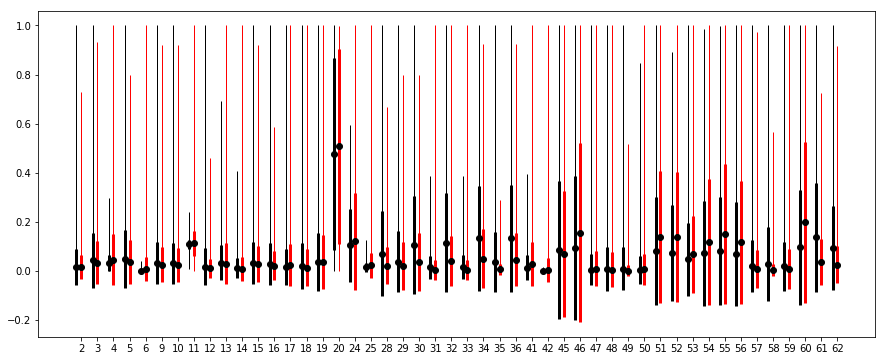

In [12]:
#CORRECT TRIPLES

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 6]

c=xf[xf['VALIDATION']==1].iloc[:,:-1]
inoNormalized=[int(noNormalized[n]) for n in range(len(noNormalized)-1)]
cols=[col for col in list(c.columns) if col not in inoNormalized]
c=c[cols]
mins = c.min().values
maxes = c.max().values
means = c.mean().values
std = c.std().values

plt.errorbar(np.arange(len(list(c.columns))), means, std, fmt='ok', lw=3)
plt.errorbar(np.arange(len(list(c.columns))), means, [means - mins, maxes - means],
             fmt='.k', ecolor='black', lw=1)

#INCORRECT TRIPLES
i=xf[xf['VALIDATION']==2].iloc[:,:-1]
inoNormalized=[int(noNormalized[n]) for n in range(len(noNormalized)-1)]
cols=[col for col in list(i.columns) if col not in inoNormalized]
i=i[cols]

mins = i.min().values
maxes = i.max().values
means = i.mean().values
std = i.std().values


plt.errorbar([i+0.3 for i in range(len(list(i.columns)))], means, std, fmt='ok',ecolor='red', lw=3)
plt.errorbar([i+0.3 for i in range(len(list(i.columns)))], means, [means - mins, maxes - means],
             fmt='.k', ecolor='red', lw=1)
plt.xticks([i+0.3 for i in range(len(list(i.columns)))], [str(i) for i in list(i.columns)])
plt.show()

The figure shows that there is a little difference between median values of the most features and it is possible look variation  on features 32, 34, 36, 51,52, 54,55, 56, 60, 61,62 and 63:
* 32 Ratio number rows where predicate holds / total rows
* 34 Ratio number relations where predicate holds / total relations
* 36 Ratio number unique relations where predicate holds / total unique relations
* 51 Number of entities in subject column (cluster)
* 52 Number of entities in object column (cluster)
* 53 Number of unique entities in subject column (cluster)
* 54 Number of unique entities in object column (cluster)
* 55 Number of potential relations (cluster)
* 56 Number of unique potential relations (cluster)
* 61 Ratio number relations where predicate holds / total relations (cluster)
* 62 Ratio number rows where predicate holds / total rows (cluster)



** Next, I explore the relation of features 32,36,61,62 with probability score of a test set.**

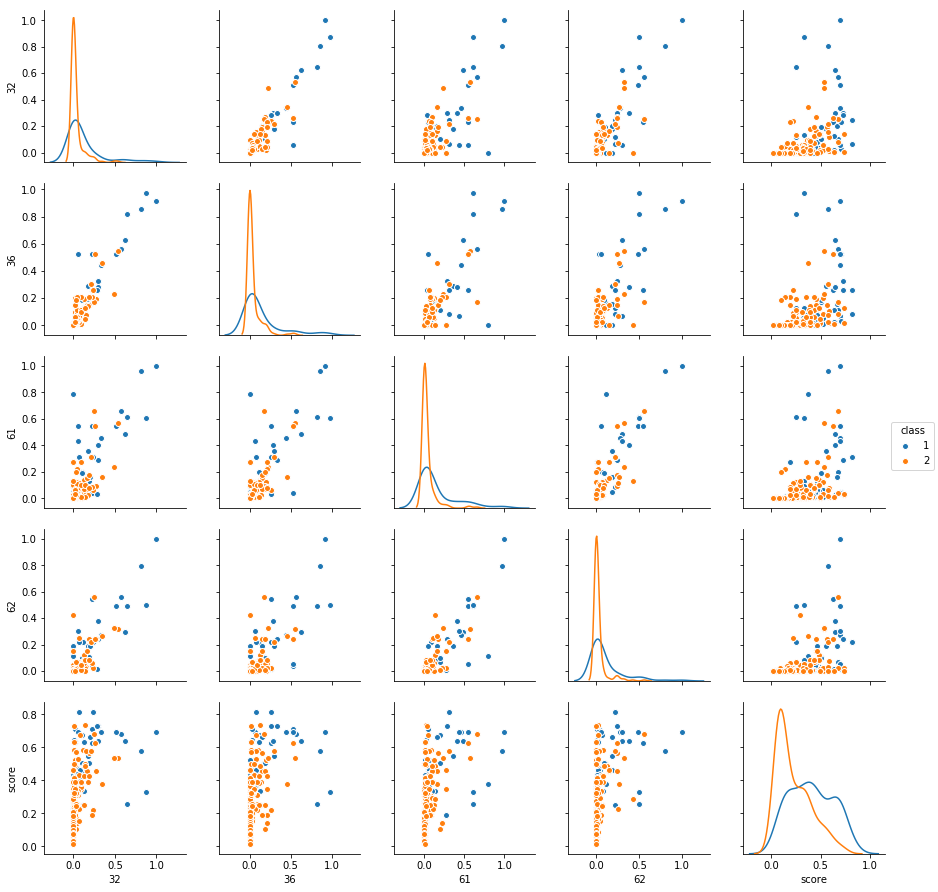

In [13]:
x_filteredf=xf[[20,48,47,49,50,42,30,28,41,39,29,40,27,45,46,26,32,36,61,62]]
y_filteredf=xf[['VALIDATION']]
#Training RF with to get probability scores
RF=RandomForestClassifier(min_samples_split=3, max_depth=5, n_estimators=5, min_samples_leaf=3, max_features=3, bootstrap=True)
Xf_train, Xf_test, yf_train, yf_test = train_test_split(x_filteredf.values, y_filteredf['VALIDATION'].values, test_size=0.3,random_state=0)
RF.fit(Xf_train, yf_train)
yf_scores=RF.predict_proba(Xf_test)
#Building a dataframe with test values
x_plot=pd.DataFrame(Xf_test,columns=[20,48,47,49,50,42,30,28,41,39,29,40,27,45,46,26,32,36,61,62])
df_score=pd.DataFrame({'score':yf_scores[:,0]})
x_plot=pd.concat([x_plot, df_score], axis=1)
x_plot=pd.concat([x_plot, pd.DataFrame({'class':yf_test})], axis=1)
x_plot.head()
#Plot a matrix with features 32,36,61,62 and probability score:
#Class 1: Correct 
#Class 2: Incorrect
import seaborn as sns
sns.pairplot(x_plot[[32,36,39,40,47,48,49,50,61,62, 'score','class']],vars=[32,36,61,62, 'score'], hue='class', diag_kind="kde")

The previous image shows that the while the number of rows and relations with same predicate icrease, the probability of being correct triples is greater.

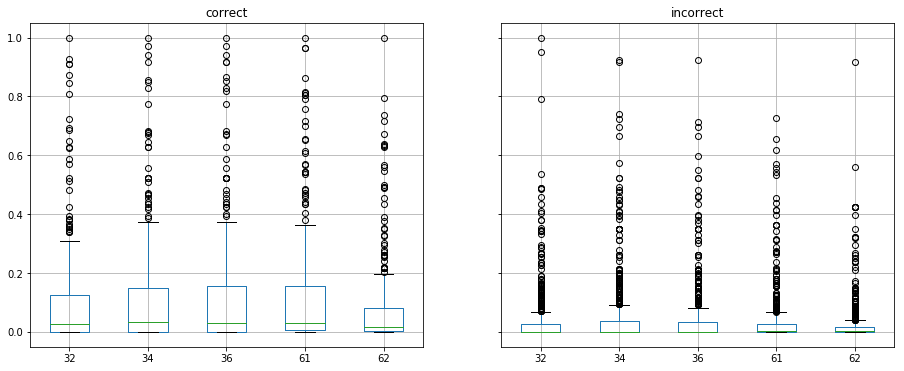

In [14]:

#32 Ratio number rows where predicate holds / total rows
#34 Ratio number relations where predicate holds / total relations
#36 Ratio number unique relations where predicate holds / total unique relations
#61 Ratio number relations where predicate holds / total relations in cluster
#62 Ratio number rows where predicate holds / total rows in cluster


c=xf[xf['VALIDATION']==1][[32,34,36,61,62]]
c.describe()

i=xf[xf['VALIDATION']==2][[32,34,36,61,62]]
i.describe()

c['key'] = 'correct'
i['key'] = 'incorrect'

DF = pd.concat([c,i],keys=['correct','incorrect'])
DFGroup = DF.groupby(['key'])
ax=DFGroup.boxplot()
plt.show()

## Removing outliers

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


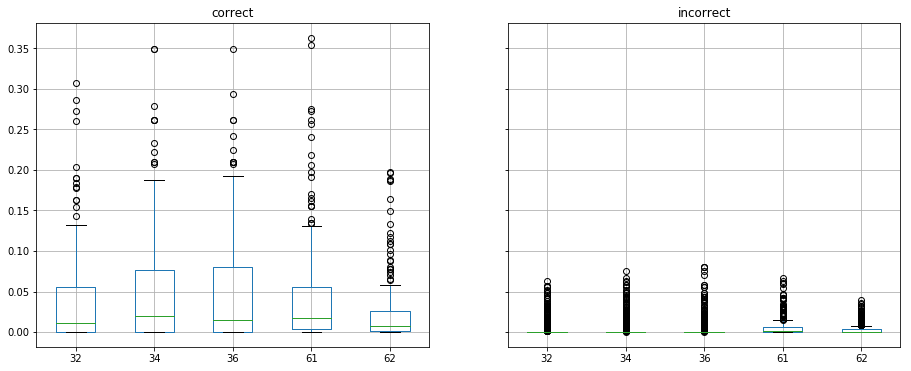

In [15]:
#Delete outiliers that are out of interquartile (Greater than 0.75 and less than 0.25) on specific features

c=xf[xf['VALIDATION']==1][[32,34,36,61,62]]
Q1 = c.quantile(0.25)
Q3 = c.quantile(0.75)
IQR = Q3 - Q1
dfoc = c[~((c < (Q1 - 1.5 * IQR)) |(c > (Q3 + 1.5 * IQR))).any(axis=1)]
dfoc['key'] = 'correct'
i=xf[xf['VALIDATION']==2][[32,34,36,61,62]]
Q1 = i.quantile(0.25)
Q3 = i.quantile(0.75)
IQR = Q3 - Q1
dfo = i[~((i < (Q1 - 1.5 * IQR)) |(i > (Q3 + 1.5 * IQR))).any(axis=1)]
dfo['key'] = 'incorrect'

DF = pd.concat([dfoc,dfo],keys=['correct','incorrect'])
DFGroup = DF.groupby(['key'])
ax=DFGroup.boxplot()
plt.show()

** Preparing data without outliers**



In [16]:
#dfoc= correct triples without outliers
#dfo= incorrect triples wihout outliers
dt=pd.concat([dfoc,dfo])
print("Total triples without outliers: ", dt.shape)
print("Total correct triples without outliers: ", dt[dt['key']=='correct'].shape)
print("Total incorrect triples without outliers: ", dt[dt['key']=='incorrect'].shape)
dt['key']=np.where(dt['key']=='correct',1, 2)
# Data for training models
setToTrain=set(dt.index.tolist())
dt=xf[xf.index.isin(list(setToTrain))]
X1=dt.iloc[:,:-1].values
Y1=dt['VALIDATION'].values

Total triples without outliers:  (655, 6)
Total correct triples without outliers:  (195, 6)
Total incorrect triples without outliers:  (460, 6)


In [17]:
dt.head()

,2,3,4,5,6,7,8,9,10,11,...,57,58,59,60,61,62,63,64,65,VALIDATION
0,0.033613,0.003184,0.02963,0.003229,0.000054,-1,2,0.001282,0.001282,0.110199,...,0.000057,0.000077,0.000055,1.0,0.000119,0.000026,0,1,82793,2
1,0.029412,0.001592,0.02963,0.001637,0.000024,-1,1,0.001282,0.001282,0.110199,...,0.000053,0.000058,0.000051,1.0,0.000096,0.000024,0,0,82793,2
2,0.029412,0.003820,0.02963,0.003866,0.000064,-1,2,0.001602,0.001602,0.110199,...,0.000003,0.000000,0.000003,1.0,0.000011,0.000002,0,1,82793,2
3,0.058824,0.002865,0.02963,0.002911,0.000052,-1,2,0.001282,0.001282,0.110199,...,0.001304,0.001696,0.001327,1.0,0.002402,0.000631,0,1,82793,2
4,0.126050,0.001592,0.02963,0.001637,0.000031,-1,2,0.000961,0.000961,0.110199,...,0.000003,0.000010,0.000003,1.0,0.000024,0.000002,0,0,82793,2


# Training models

In [18]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedKFold
def classify(X, Y, weighted=True):
    warnings.simplefilter(action='ignore', category=FutureWarning)    
    # Cross validation with 40 splits,  each time with 20% as validation set.
    kf = StratifiedShuffleSplit(n_splits=10, test_size=0.2) 
    cl1 = KNeighborsClassifier(n_neighbors=1)
    cl2 = DecisionTreeClassifier()
    cl3 = RandomForestClassifier(max_depth=10,random_state=101, max_features=None, min_samples_leaf=3)
    cl4=  SVC(kernel='linear')
    cl5 = GaussianNB()
    p1= p2= p3= p4 =p5=0 
    r1=r2=r3=r4=r5=0
    f1=f2=f3=f4=f5=0
    cont=0
    pacum=[]

    for train_index, test_index in kf.split(X, Y): 
            #print("Train:", train_index, "Validation:", test_index) 
            X_train, X_test = X[train_index], X[test_index] 
            y_train, y_test = Y[train_index], Y[test_index]

            cl1 = KNeighborsClassifier(n_neighbors=1)
            cl2 = DecisionTreeClassifier()
            cl3 = RF = RandomForestClassifier(bootstrap=True, max_depth= 100, max_features=10, min_samples_leaf=3, min_samples_split=5, n_estimators=100)#RandomForestClassifier(max_depth=10,max_features=None, min_samples_leaf=3)
            #cl4=  SVC(kernel='linear')
            cl5 = GaussianNB()

            #print(X_train)
            #print('----')
            #print(y_train)
            #print('KNN---------------')
            #cl1 = KNeighborsClassifier(n_neighbors=1)
            #X_train, X_test, y_train, y_test = train_test_split(xf, y, test_size=0.3, random_state=4)
            cl1.fit(X_train, y_train)
            y_pred = cl1.predict(X_test)
            if weighted:
                labels=[1,2]
            else:
                labels=[1]
                
            p1+=precision_score(y_test, y_pred, labels=labels,average='weighted') 
            r1+=recall_score(y_test, y_pred, labels=labels,average='weighted') 
            f1+=f1_score(y_test, y_pred, labels=labels,average='weighted') 
            #print('KNN')
            #print(classification_report(y_test, y_pred))
            #print('Decision Tree --------------')

            cl2.fit(X_train, y_train)    
            y_pred=cl2.predict(X_test)
            p2+=precision_score(y_test, y_pred, labels=labels,average='weighted') 
            r2+=recall_score(y_test, y_pred, labels=labels,average='weighted') 
            f2+=f1_score(y_test, y_pred, labels=labels,average='weighted') 
            #print('Decision Tree')
            #print(classification_report(y_test, y_pred))
            #print (sorted(zip(map(lambda x: round(x, 4), cl2.feature_importances_), list(xf.columns)), 
            #         reverse=False))

            cl3.fit(X_train, y_train)
            y_pred=cl3.predict(X_test)
            ps=precision_score(y_test, y_pred, labels=labels,average='weighted') 
            pacum.append(ps)
            p3+=ps 
            r3+=recall_score(y_test, y_pred, labels=labels,average='weighted') 
            f3+=f1_score(y_test, y_pred, labels=labels,average='weighted') 
            #print('Random')
            #print(cl3.feature_importances_)
            #print (sorted(zip(map(lambda x: round(x, 4), cl3.feature_importances_), list(xf.columns)), 
            #         reverse=False))
            #print(classification_report(y_test, y_pred))

            #cl4.fit(X_train, y_train)        
            #y_pred=cl4.predict(X_test)    
            #p4+=precision_score(y_test, y_pred, average='weighted') 
            #r4+=recall_score(y_test, y_pred, average='weighted') 
            #f4+=f1_score(y_test, y_pred, average='weighted') 
            #print('Logistic')
            #print(classification_report(y_test, y_pred))

            cl5.fit(X_train, y_train)
            y_pred=cl5.predict(X_test)
            p5+=precision_score(y_test, y_pred, labels=labels,average='weighted') 
            r5+=recall_score(y_test, y_pred, labels=labels,average='weighted') 
            f5+=f1_score(y_test, y_pred, labels=labels,average='weighted') 
            #print('Naive Bayes')
            #print(classification_report(y_test, y_pred))


            cont+=1
            #print('Set y: ', [ip for ip in y_test if ip==1])
    print('***  KNN  ***')
    print('Precision: ', p1/cont)
    print('Recall: ', r1/cont)
    print('F1-score: ', f1/cont)
    print('***  Decision Tree  ***')
    print('Precision: ', p2/cont)
    print('Recall: ', r2/cont)
    print('F1-score: ', f1/cont)
    print('***  Random Forest  ***')
    print('Precision: ', p3/cont)
    print('Recall: ', r3/cont)
    print('F1-score: ', f3/cont)
    print('***  Naive Bayes  ***')
    print('Precision: ', p5/cont)
    print('Recall: ', r5/cont)
    print('F1-score: ', f5/cont)
    #print(pacum)
    #print('***  SVC  ***')
    #print('Precision: ', p4/cont)
    #print('Recall: ', r4/cont)
    #print('F1-score: ', f4/cont)
    #print(classification_report(y_test, y_pred))



## Classification  (Cross Validation)

* (X,Y): initial data 
* (X1,Y1): initial data without outliers 
* (X2,Y2): initial data + "contextual triples" updated 
* (X3,Y3): initial data + Correct triples (existent in Wikidata)
* (X3,Y3): initial data + Correct triples (existent in Wikidata) without outliers

**Initial data**

In [19]:
classify(X,Y)

***  KNN  ***
Precision:  0.6551935365491673
Recall:  0.656140350877193
F1-score:  0.6548742502488043
***  Decision Tree  ***
Precision:  0.7211711382136509
Recall:  0.7163742690058481
F1-score:  0.6548742502488043
***  Random Forest  ***
Precision:  0.7755301865708683
Recall:  0.7859649122807018
F1-score:  0.7691567026538851
***  Naive Bayes  ***
Precision:  0.6909754378244173
Recall:  0.44385964912280695
F1-score:  0.42841309634615393


** Classification initial data without outliers**

In [20]:
classify(X1,Y1)

***  KNN  ***
Precision:  0.6766616599004626
Recall:  0.6725190839694657
F1-score:  0.6733396323575936
***  Decision Tree  ***
Precision:  0.7501867432470954
Recall:  0.750381679389313
F1-score:  0.6733396323575936
***  Random Forest  ***
Precision:  0.7768892039067241
Recall:  0.783969465648855
F1-score:  0.7676390447566449
***  Naive Bayes  ***
Precision:  0.6650322977568639
Recall:  0.7015267175572519
F1-score:  0.6643410023206796


** Classification data + "contextual" triples** 

In [21]:
classify(X2,Y2)

***  KNN  ***
Precision:  0.626786641606685
Recall:  0.6255555555555554
F1-score:  0.6256285229470496
***  Decision Tree  ***
Precision:  0.7275482912978802
Recall:  0.7261111111111112
F1-score:  0.6256285229470496
***  Random Forest  ***
Precision:  0.7669745676793254
Recall:  0.7883333333333332
F1-score:  0.7632502071677354
***  Naive Bayes  ***
Precision:  0.6491652768597546
Recall:  0.4477777777777779
F1-score:  0.42627619079769197


The results improve removing outiliers, with a small difference of 0.03%.  

## Testing best model over new data (outliers)

In [22]:
setAll=set(xf.index.tolist())
setFiltered=setAll-setToTrain
outliers1=xf[xf.index.isin(list(setFiltered))]
print("Outliers: ", outliers1.shape[0])
RF=  RandomForestClassifier(max_depth=3,random_state=101, max_features=None, min_samples_leaf=3)
RF.fit(X1,Y1)
X_test1=outliers1.iloc[:,:-1].values
y_test1=outliers1['VALIDATION'].values
y_pred1=RF.predict(X_test1)
print(classification_report(y_test1, y_pred1))
print("OUTLIERS")
print(y_test1)
print("PREDICTED")
print(y_pred1)

Outliers:  197
              precision    recall  f1-score   support

           1       0.27      1.00      0.43        50
           2       1.00      0.08      0.15       147

   micro avg       0.31      0.31      0.31       197
   macro avg       0.64      0.54      0.29       197
weighted avg       0.81      0.31      0.22       197

OUTLIERS
[2 2 1 2 2 2 1 2 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 1 2 2 1 2
 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 1 2 2 2
 1 2 1 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 1 1 1 2 1 1 2 1 2 2 2 2 2 2 1 2 2 1 2
 2 1 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2
 2 2 2 2 2 2 2 1 2 2 1 2 2 1 2 2 2 2 1 2 2 2 2 1 1 1 1 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2]
PREDICTED
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

**0.27% precision for class 1 applying Random Forest and just 0.31% in average recall is not enough**

In [23]:
# OUTLIERS
data[data.index.isin(outliers1[outliers1['VALIDATION']==1].index.tolist())][['47','48','49','50','61','62','TABLE','CELL','NAME_COL1','NAME_COL2','ENTITY_COL1','PREDICATE','ENTITY_COL2']].head(2)

,47,48,49,50,61,62,TABLE,CELL,NAME_COL1,NAME_COL2,ENTITY_COL1,PREDICATE,ENTITY_COL2
55,58817,6,0,58817,0.602756,0.533935,560380.10,3:3:2,player@3,posit@3,https://en.wikipedia.org/wiki/Vladimir_Nikolov...,P413 :position played on team / speciality@en,https://en.wikipedia.org/wiki/Midfielder :Q193592
68,372150,8,1,17465,0.559276,0.477559,804035.2,13:3:1,player@3,spancol@4,https://en.wikipedia.org/wiki/Kim_Young-wook :...,P27 :country of citizenship@en,https://en.wikipedia.org/wiki/South_Korea :Q884


#DATA WITHOUT OUTLIERS

### Applying Stochastic Gradient Descent Classifier for getting thresholds

In [24]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X1,Y1)
ys_pred=sgd_clf.predict(X_test1)
print(classification_report(y_test1, ys_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        50
           2       0.75      1.00      0.85       147

   micro avg       0.75      0.75      0.75       197
   macro avg       0.37      0.50      0.43       197
weighted avg       0.56      0.75      0.64       197



/home/jhomara/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
#y_scores=sgd_clf.decision_function(X_test)
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve


def plot_precision_recall_vs_threshold(fig, precisions, recalls, thresholds):
    fig.plot(thresholds, precisions[:-1], "b-", label="Precision")
    fig.plot(thresholds, recalls[:-1], "g--", label="Recall")
    fig.set_xlabel("Threshold")
    fig.legend(loc="center left")
    fig.set_ylim([0,1])


### **Precision vs Recall Random SGD**

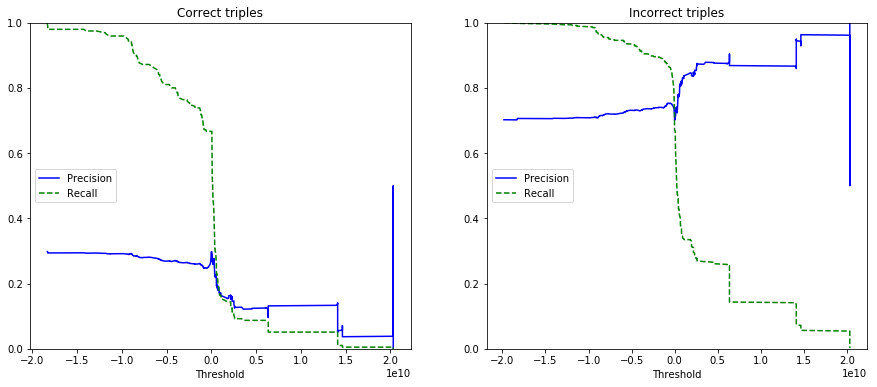

In [26]:
f, (ax1,ax2)=plt.subplots(1,2)
y_scores1=cross_val_predict(sgd_clf, X1, Y1, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(Y1,y_scores1, pos_label=1)
plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds)
ax1.set_title("Correct triples")
precisions, recalls, thresholds = precision_recall_curve(Y1,y_scores1, pos_label=2)
plot_precision_recall_vs_threshold(ax2, precisions, recalls, thresholds)
ax2.set_title("Incorrect triples")
plt.show()

### Precision vs Recall Random Forest 

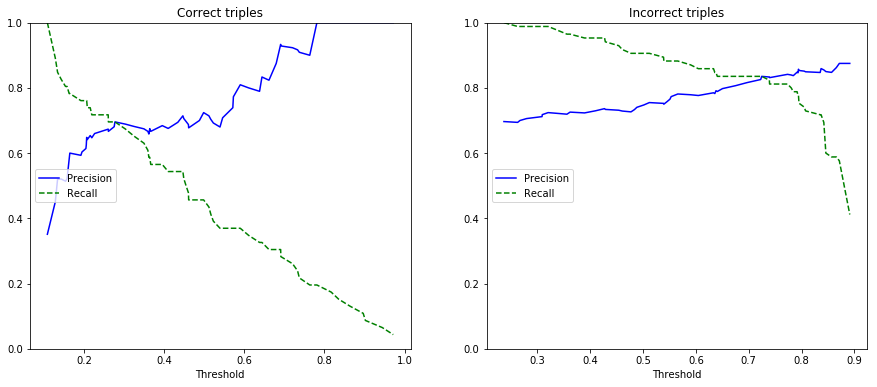

In [27]:
from sklearn.model_selection import train_test_split

f, (ax1,ax2)=plt.subplots(1,2)
RF=RandomForestClassifier(max_depth=3,random_state=101, max_features=None, min_samples_leaf=3)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.2,random_state=0)
RF.fit(X_train1, y_train1)
y_scores1=RF.predict_proba(X_test1)

precisions, recalls, thresholds = precision_recall_curve(y_test1,y_scores1[:,0], pos_label=1)
plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds)
ax1.set_title("Correct triples")
precisions, recalls, thresholds = precision_recall_curve(y_test1,y_scores1[:,1], pos_label=2)
plot_precision_recall_vs_threshold(ax2, precisions, recalls, thresholds)
ax2.set_title("Incorrect triples")
plt.show()

### ROC (Receiver operating characteristic) True Positive Rate vs False Positive Rate (TPR vs FPR)

In [28]:
from sklearn.metrics import roc_curve, auc
def probability_analysis(fig, X,Y, X_test=None, y_test=None, label=1):
    RF=RandomForestClassifier(max_depth=3,random_state=101, max_features=None, min_samples_leaf=3)
    if X_test is not None:
        X_train=X
        y_train=Y
        if label==1:
            y_score = RF.fit(X_train, y_train).predict_proba(X_test)[:, 0]
        else:
            y_score = RF.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)
        if label==1:
            y_score = RF.fit(X_train, y_train).predict_proba(X_test)[:, 0]
        else:
            y_score = RF.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #labels=[1,2]
    th=dict()
    #for i in labels:
    fpr[label], tpr[label], th[label] = roc_curve(y_test, y_score,  pos_label=label)
    roc_auc[label] = auc(fpr[label], tpr[label])
    print(roc_auc)
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel(), pos_label=label)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print(roc_auc)
    plt.figure()
    lw = 2
    fig.plot(fpr[label], tpr[label], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[label])
    fig.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    fig.set_xlim([0.0, 1.0])
    fig.set_ylim([0.0, 1.05])
    fig.set_xlabel('False Positive Rate')
    fig.set_ylabel('True Positive Rate')
    fig.set_title('Receiver operating characteristic example - Random Forest')
    fig.legend(loc="lower right")

{1: 0.7994884910485933}
{1: 0.7994884910485933, 'micro': 0.7994884910485933}
{2: 0.7994884910485933}
{2: 0.7994884910485933, 'micro': 0.7994884910485933}


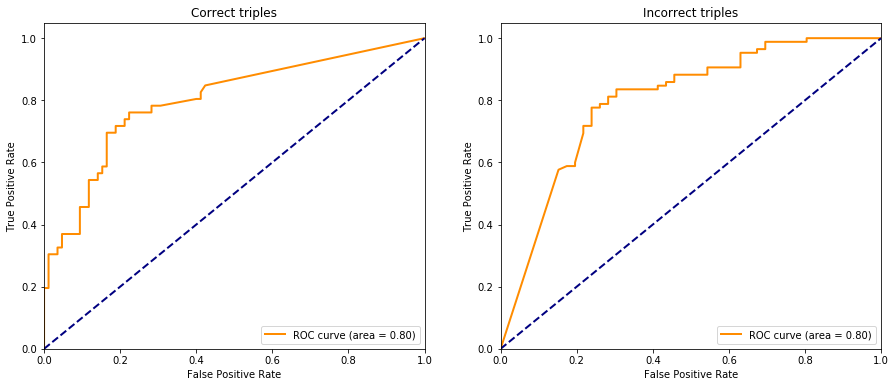

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

In [29]:
f, (ax1,ax2)=plt.subplots(1,2)
probability_analysis(ax1,X1,Y1, label=1)
ax1.set_title("Correct triples")
probability_analysis(ax2,X1,Y1, label=2)
ax2.set_title("Incorrect triples")
plt.show()

** The figure shows that algorithm can differentiate both classes with 0.80% probability, if we increase the threshold for more positive values (TRP), we could get more false positives (Decrease the specificity FPR). **

### Evaluating model with additional features:

In [30]:
Xt=dt.copy()
del Xt[31]
del Xt[32]
del Xt[33]
del Xt[34]
del Xt[35]
del Xt[36]
del Xt[61]
del Xt[62]
Xt=Xt.iloc[:,:-1].values
Yt=dt['VALIDATION'].values
classify(Xt,Yt)

***  KNN  ***
Precision:  0.6801891526394396
Recall:  0.6656488549618321
F1-score:  0.6706386868197199
***  Decision Tree  ***
Precision:  0.7036921489770468
Recall:  0.6923664122137404
F1-score:  0.6706386868197199
***  Random Forest  ***
Precision:  0.7710344979715046
Recall:  0.7809160305343511
F1-score:  0.769494388169708
***  Naive Bayes  ***
Precision:  0.6729901621015347
Recall:  0.7068702290076335
F1-score:  0.6681467876974924


In [31]:
Xt=dt.copy()
Xt=Xt[[32,36,61,62]].values
Yt=dt['VALIDATION'].values
classify(Xt,Yt)

ValueError: max_features must be in (0, n_features]



If we evaluate the models using the remainder features instead of features: 32,34,61 and 62 the precision and recall held,  but if I remove them the results decrease a bit. (~0.02), then I will keep all features.



# Adding data to training set (correct triples)

In [ ]:
dataCorrect = pd.read_csv('sampleCorrect300.csv',sep="\t", decimal=",", index_col=False)
print("Size: ", data.shape)
#data1=data[data['ORIGIN']=='f']
dataCorrect=pd.merge(dataCorrect, clusters, on=['CLUSTER'])
dataCorrect.head(3)


## Testing models over new training set

In [ ]:
#Append new data to initial group.
print("New data:")
xf1=filterFeatures(dataCorrect)
xfNew=xf.append(xf1)
xfNew.shape
X3=xfNew.iloc[:,:-1].values
Y3=xfNew['VALIDATION'].values
print("New training set")
print("New number of correct triples:", xfNew[xfNew['VALIDATION']==1].shape[0])
print("New number of incorrect triples:", xfNew[xfNew['VALIDATION']==1].shape[0])
classify(X3,Y3)

Adding correct triples to training set the results improve significantly, achieving 0.82% precision and recall with Random Forest and 0.78% with Decision Tree models.

## Plotting curves with new Training set

### Precision vs Recall (new training set)

In [ ]:
f, (ax1,ax2)=plt.subplots(1,2)
RF=RandomForestClassifier(max_depth=3,random_state=101, max_features=None, min_samples_leaf=3)
X_train3, X_test3, y_train3, y_test3= train_test_split(X3, Y3, test_size=0.2,random_state=0)
RF.fit(X_train3, y_train3)
y_scores3=RF.predict_proba(X_test3)

precisions, recalls, thresholds = precision_recall_curve(y_test3,y_scores3[:,0], pos_label=1)
plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds)
ax1.set_title("Correct triples")

precisions, recalls, thresholds = precision_recall_curve(y_test3,y_scores3[:,1], pos_label=2)
plot_precision_recall_vs_threshold(ax2, precisions, recalls, thresholds)
ax2.set_title("Incorrect triples")
plt.show()

The figure shows that increasing the training set, the precision and also recall improve

### Setting Threshold

We can move the threshold to gain precision without lossing recall significally

In [ ]:
y_pred_33=np.where(y_scores3[:,0]>=0.55,1,2)
print("Precision:", precision_score(y_test3, y_pred_33))
print("Recall: ", recall_score(y_test3, y_pred_33))

### ROC curve (new training set)

In [ ]:
#Plot ROC curve for all data, including correct triples added. 

f, (ax1,ax2)=plt.subplots(1,2)
probability_analysis(ax1,X2,Y2, label=1)
ax1.set_title("Correct triples")
probability_analysis(ax2,X2,Y2, label=2)
ax2.set_title("Incorrect triples")
plt.show()

### Removing outliers from new training set

Remove outliers in features:32,34,36,61,62 over new dataset, train model and test over removed data

In [ ]:
c=xfNew[xfNew['VALIDATION']==1][[32,34,36,61,62]]
Q1 = c.quantile(0.25)
Q3 = c.quantile(0.75)
IQR = Q3 - Q1
dfoc = c[~((c < (Q1 - 1.5 * IQR)) |(c > (Q3 + 1.5 * IQR))).any(axis=1)]
dfoc['key'] = 'correct'

i=xfNew[xfNew['VALIDATION']==2][[32,34,36,61,62]]
Q1 = i.quantile(0.25)
Q3 = i.quantile(0.75)
IQR = Q3 - Q1
dfo = i[~((i < (Q1 - 1.5 * IQR)) |(i > (Q3 + 1.5 * IQR))).any(axis=1)]
dfo['key'] = 'incorrect'

DF = pd.concat([dfoc,dfo],keys=['correct','incorrect'])
DFGroup = DF.groupby(['key'])
ax=DFGroup.boxplot()
plt.show()

In [ ]:
#Training Naive Bayes:
#Measure evaluated for correct triples
dt1=pd.concat([dfoc,dfo])
print("Total triples without outliers: ", dt1.shape)
print("Total correct triples without outliers: ", dt1[dt1['key']=='correct'].shape)
print("Total incorrect triples without outliers: ", dt1[dt1['key']=='incorrect'].shape)
dt1['key']=np.where(dt1['key']=='correct',1, 2)
"""
del xfNew[31]
del xfNew[32]
del xfNew[33]
del xfNew[34]
del xfNew[35]
del xfNew[36]
"""
setAll=set(xfNew.index.tolist())
setToTrain=set(dt1.index.tolist())
alld=xfNew[xfNew.index.isin(list(setToTrain))]

X4=alld.iloc[:,:-1].values
Y4=alld['VALIDATION'].values

setFiltered=setAll-setToTrain
outliers=xfNew[xfNew.index.isin(list(setFiltered))]
print("Outliers: ", outliers.shape[0])
RF=RandomForestClassifier(max_depth=3,random_state=101, max_features=None, min_samples_leaf=3)
RF.fit(X4,Y4)
X_test4=outliers.iloc[:,:-1].values

y_test4=outliers['VALIDATION'].values
y_pred4=RF.predict(X_test4)
print(classification_report(y_test4, y_pred4))
print("OUTLIERS")
print(y_test4)
print("PREDICTED")
print(y_pred4)

Again the model does not predict well outliers, which in this case are all negative. The algorithm gets a high probability  that they have a high probability of being positives. 

### ROC Curve for new  training set without outliers

In [ ]:
f, (ax1,ax2)=plt.subplots(1,2)
RF=RandomForestClassifier(max_depth=3,random_state=101, max_features=None, min_samples_leaf=3)
X_train4, X_test4, y_train4, y_test4= train_test_split(X4, Y4, test_size=0.2,random_state=0)
RF.fit(X_train4, y_train4)
y_scores4=RF.predict_proba(X_test4)

precisions, recalls, thresholds = precision_recall_curve(y_test4,y_scores4[:,0], pos_label=1)
plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds)
ax1.set_title("Correct triples")

precisions, recalls, thresholds = precision_recall_curve(y_test4,y_scores4[:,1], pos_label=2)
plot_precision_recall_vs_threshold(ax2, precisions, recalls, thresholds)
ax2.set_title("Incorrect triples")
plt.show()

### Setting the threshold

In [ ]:
y_pred_44=np.where(y_scores4[:,0]>=0.55,1,2)
print("Precision:", precision_score(y_test4, y_pred_44))
print("Recall: ", recall_score(y_test4, y_pred_44))


# Regression Models (with Initial Data)

In [ ]:
X_trainR, X_testR, y_trainR, y_testR = train_test_split(X1, Y1, test_size=0.3,shuffle=3)

** Logistic Regression**

In [ ]:
lr=LogisticRegression()
lr.fit(X_trainR, y_trainR)
pred_lr=lr.predict(X_testR)
print(classification_report(pred_lr, y_testR))

In [ ]:
y_traintR=np.where(y_train4==1,0.75,0.45)
y_testtR=np.where(y_test4==1,0.75,0.45)

**Other models**

In [ ]:
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(max_iter=100),
    linear_model.BayesianRidge(),    
    RandomForestRegressor()]

for item in classifiers:
    #print(item)
    clf = item
    print("\n")
    print("***** ",type(clf).__name__," *****"+"\n")  
    clf.fit(X_trainR, y_trainR)
    predR=clf.predict(X_testR)
    #print('Accuracy of {} on test set: {:.2f}'.format(type(clf).__name__,logreg.score(X_test3, y_testt3)))

    print("R2 score : %.2f" % r2_score(y_testR,predR))
    print("Mean squared error: %.2f" % mean_squared_error(y_testR, predR))
    er = []
    g = 0
    meany=np.mean(predR)
    for i in range(len(y_testR)):
        #print( "actual=", y_testt3[i], " observed=", pred3[i])
        x = (y_testR[i] - predR[i]) **2
        er.append(x)        
        g = g + x

    x = 0
    for i in range(len(er)):
        x = x + er[i]
    print ("MSE", x / len(er))

    v = np.var(er)
    print ("variance", v)
    print ("average of errors ", np.mean(er))
    m = np.mean(y_testR)
    print ("average of observed values", m)

    y = 0
    for i in range(len(y_testR)):
        y = y + ((y_testR[i] - m) ** 2)

    print ("total sum of squares", y)
    print ("ẗotal sum of residuals ", g)
    print ("r2 calculated", 1 - (g / y))

R2 score reached negative values, meaning that the regression function  doesn't achive better results than mean values. The max value achieved was using Random Forest Regressor with R2 close to 0.5% and MSE of 0.15

# Tunning Random Forest

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))    
    return accuracy

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
base_accuracy=70
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10, 30, 50, 100],
    'max_features': [3,6,10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3,5, 10, 12],
    'n_estimators': [5,10, 50, 100, 200]
}
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train4, y_train4)
print("Best paramenters: ")
# {'bootstrap': True, 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 10}
print(grid_search.best_params_)
y_testt4=np.where(y_test4==1,1,0)
y_traint4=np.where(y_train4==1,1,0)

best_grid = grid_search.best_estimator_
predictions = best_grid.predict_proba(X_test4)

grid_accuracy = evaluate(best_grid, X_test4, y_test4)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))



In [ ]:
X.shape

In [ ]:
#After setting parameters testing with initial data
classify(X,Y)

## Saving Model

In [ ]:
#Saving trained model
import pickle
RF = RandomForestClassifier(bootstrap=True, max_depth= 100, max_features=10, min_samples_leaf=3, min_samples_split=5, n_estimators=100)
RF.fit(X,Y)
filename = 'trainedModelRF.sav'
pickle.dump(RF, open(filename, 'wb'))

# Some stats

## Models comparison

In [ ]:
# Compare Algorithms Weighted average
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

seed = 7
models = []
cl1 = KNeighborsClassifier(n_neighbors=1)
cl2 = DecisionTreeClassifier()
cl3 = RandomForestClassifier(max_depth=10,max_features=None, min_samples_leaf=3)
cl4=  SVC(kernel='linear')
cl5 = GaussianNB()
models.append(('KNN',cl1))
models.append(('DT', cl2))
models.append(('RF', cl3))
#models.append(('SVM', cl4))
models.append(('GNB', cl5))
results = []
names = []
scoring = 'f1_weighted'
for name, model in models:
    #kfold = model_selection.KFold(n_splits=40, random_state=seed)
    kfold = StratifiedShuffleSplit(n_splits=40, test_size=0.2) 
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
#Graph decision Tree 
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
model = RandomForestClassifier(n_estimators=10)
Xtree=xf[[14,17,20,19,36,8,25,24,6,4,35,34,18,32,13,7,11,33,10,15,9,3,2]]
print(Xtree.head(2))
Xtreev=Xtree.values

model.fit(Xtreev, y)
fnames=[str(fn) for fn in list(Xtree.columns)]
cnames=[str(v) for v in set(y.values)]
print(fnames)
print(cnames)

estimator = model.estimators_[0]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = fnames,
                class_names = cnames,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')"""

## Learning curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.10, 1.0, 20)):
    
    plt.figure(figsize=(6,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    print('learning curve')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_weighted')
    print('learning curve2')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curve (Random Forest)"
# Cross validation with 40 splits,  each time with 20% as validation set.
cv = StratifiedShuffleSplit(n_splits=40, test_size=0.2, random_state=7)
estimator = RandomForestClassifier(max_depth=10,random_state=101, max_features=None, min_samples_leaf=3)
print('estimator 1')
plot_learning_curve(estimator, title, X1, Y1, ylim=(0.1, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (Decision Tree)"
cv = StratifiedShuffleSplit(n_splits=40, test_size=0.2, random_state=7)

estimator = DecisionTreeClassifier()
print('estimator 2')
plot_learning_curve(estimator, title, X1, Y1, (0.1, 1.01), cv=cv, n_jobs=4)


plt.show()

## Feature importances

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
#Compute feature importances
forest = ExtraTreesClassifier()
forest.fit(X1, Y1)
columns=np.array(xf.columns)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
indices=indices[0:15]
indices=indices[::-1]
print(len(indices))

col=columns[indices]
print('cols:', col)
# Print the feature ranking
print("Feature ranking:")
lenx=15
print(len(range(lenx)))
for f in range(lenx):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(7,5))
plt.title("Feature importances")
plt.barh(range(lenx), importances[indices],
       color="b", align="center")
plt.yticks(range(lenx), col)
#plt.xlim([-1, lenx])
plt.show()